In [1]:
from __future__ import division, unicode_literals, print_function # for compatibility with python 2 and 3
import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to matplot notebook for inline plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure', figsize=(10,5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series # for convenience

import pims
import trackpy as tp

In [3]:
@pims.pipeline
def gray(image):
    return image[:,:,1] # take just the green channel

frames = gray(pims.open('../pngimgs/*.png'))

In [4]:
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /home/tarnished-dan22/INBRE/CounterCell-INBRE-Project/pngimgs/*.png
    Length: 39 frames
    Frame Shape: (1100, 804, 3)
    Pixel Datatype: uint8

In [5]:
print(frames[0]) # print the first frame

[[23 23 24 ... 25 24 24]
 [22 21 22 ... 22 22 22]
 [21 20 20 ... 22 23 23]
 ...
 [25 22 22 ... 22 22 22]
 [23 22 25 ... 18 21 23]
 [22 23 28 ... 15 21 25]]


Frame([[23, 23, 24, ..., 25, 24, 24],
       [22, 21, 22, ..., 22, 22, 22],
       [21, 20, 20, ..., 22, 23, 23],
       ...,
       [25, 22, 22, ..., 22, 22, 22],
       [23, 22, 25, ..., 18, 21, 23],
       [22, 23, 28, ..., 15, 21, 25]], dtype=uint8)
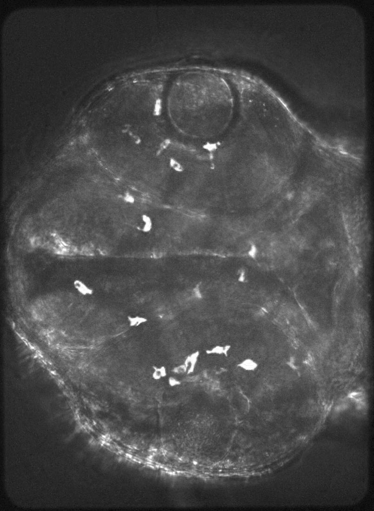

In [6]:
frames[0]

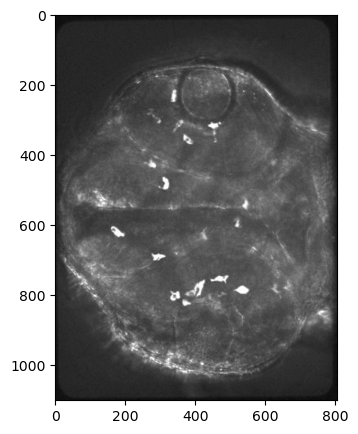

In [7]:
plt.imshow(frames[0])

In [8]:
frames[25].frame_no

25

In [16]:
frames[25].metadata # Scientific formats can pass experiment meta data here

{}

In [10]:
'''Start with just the first frame. Estimate the size of the features (in pixels). 
The size must be an odd integer, and it is better to err on the large side, 
as we'll see below. We estimate 11 pixels.'''

f = tp.locate(frames[0], 11, invert=False)
# the algorithm looks for bright features; since the features in this set
# of images are bright we set the inverse parameter to False.
# if we were identifying dark objects we would set the invert to True.

#locate returns a spreadsheet-like object called a DataFrame. it lists

# - each feature's position
# - various chacterizations of its appearance, which will use the filter
# out spurious(features that do not fit our predictions and are considered to be false) 
# features.

# - the "signal" strength and an estimate of uncertainty.

In [11]:
f.head() # show the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,3.848168,266.910995,66.275785,2.361338,0.079205,4.510917,1868.0,-0.255957,0
1,6.868571,76.914286,60.723887,3.237283,0.553411,4.857911,1896.0,-0.258761,0
2,10.095420,15.805344,90.912334,2.747657,0.171345,4.163924,1798.0,-0.249206,0
3,13.735521,722.538610,179.742706,3.045980,0.138427,5.898892,3479.0,-0.679682,0
4,10.657407,772.782407,74.950626,3.255337,0.198632,3.816930,1803.0,-0.249677,0


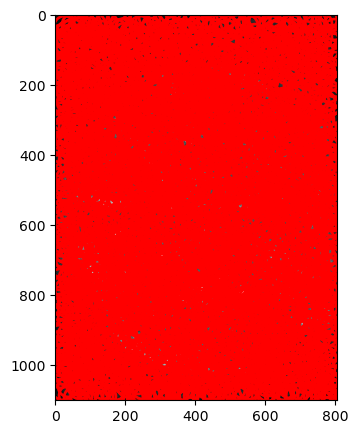

<AxesSubplot: >

In [12]:
tp.annotate(f, frames[0])

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

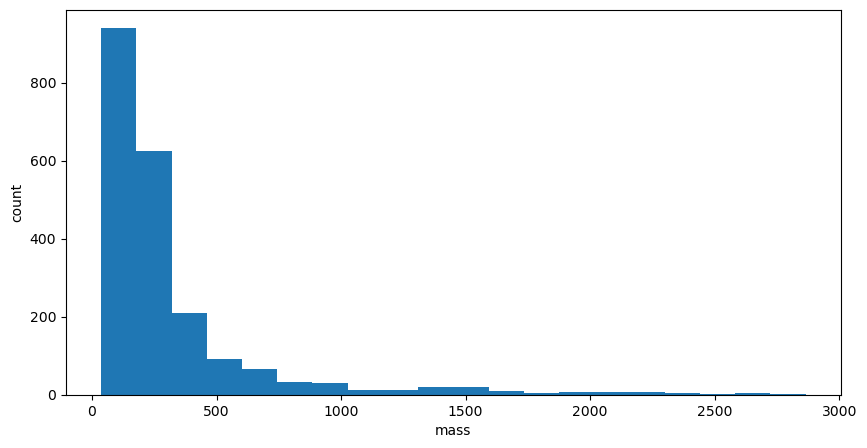

In [13]:
# Refine parameters to eliminate spurious features
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

#optionally, label the axes
ax.set(xlabel='mass', ylabel='count')

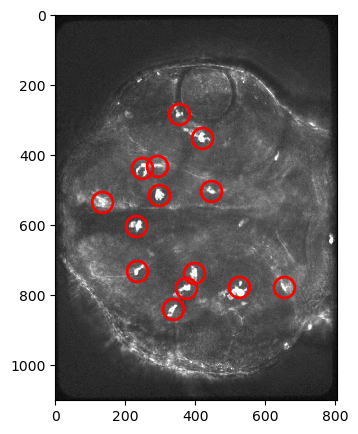

In [41]:
# segment the image first
f = tp.locate(frames[1], # the first image
              35, # total pixel size of your blob (must be odd number)
              # invert= are the objects light(false) or dark(True)
              # topn=25,
              topn=14,
              minmass=10) # minimum mass size for the blob
tp.annotate(f, frames[1]);

array([[<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'y'}>]], dtype=object)

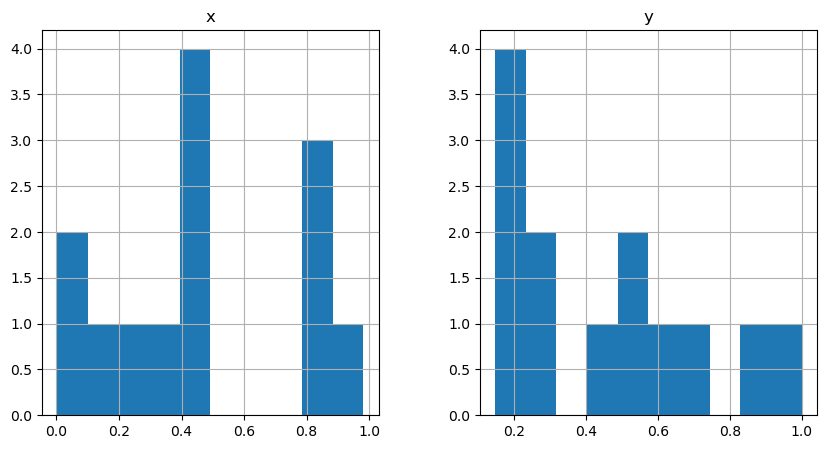

In [19]:
tp.subpx_bias(f)

In [20]:
f = tp.batch(frames[:40], 37, topn=13, minmass=10)

Frame 38: 13 features


In [21]:
# tp.quiet() # turn off progress report for best performance

t= tp.link(f, 5, memory=3)

Frame 38: 13 trajectories present.


In [22]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,541.436876,542.784738,25757.559624,7.762533,0.306497,117.346513,151121.0,0.009085,0,0
12,785.025226,532.339711,47948.462250,10.295304,0.263096,111.704854,182170.0,0.007268,0,1
11,618.154967,174.871370,44385.754412,10.836828,0.403399,128.065666,159273.0,0.008525,0,2
10,482.240031,315.861742,43775.891044,10.204922,0.468605,130.322329,159564.0,0.008506,0,3
8,802.200038,342.284905,42112.729887,10.447688,0.228974,120.731509,164950.0,0.008175,0,4


In [23]:
t1 = tp.filter_stubs(t, 1)
# compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 365
After: 365


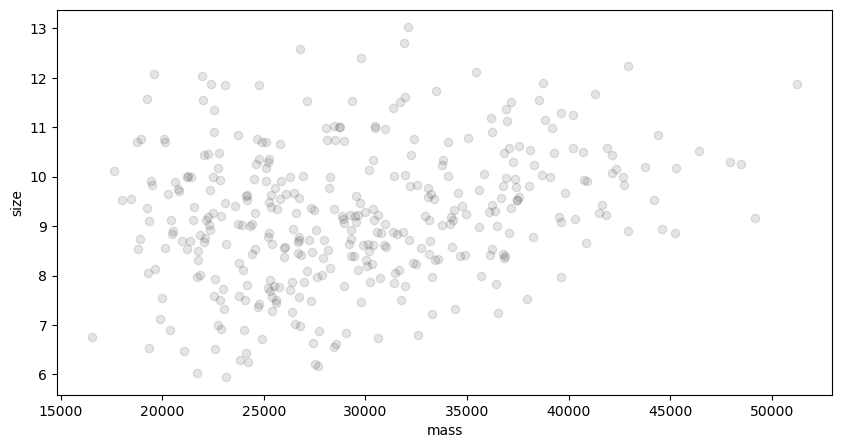

<AxesSubplot: xlabel='mass', ylabel='size'>

In [24]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean())

In [29]:
t2 = t1[((t1['mass'] > 10) & (t1['size'] < 10.8) & (t1['ecc'] < 0.46))]

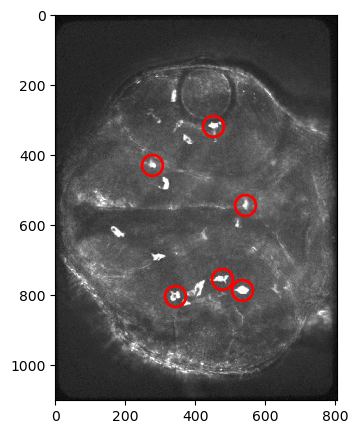

<AxesSubplot: >

In [35]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0])

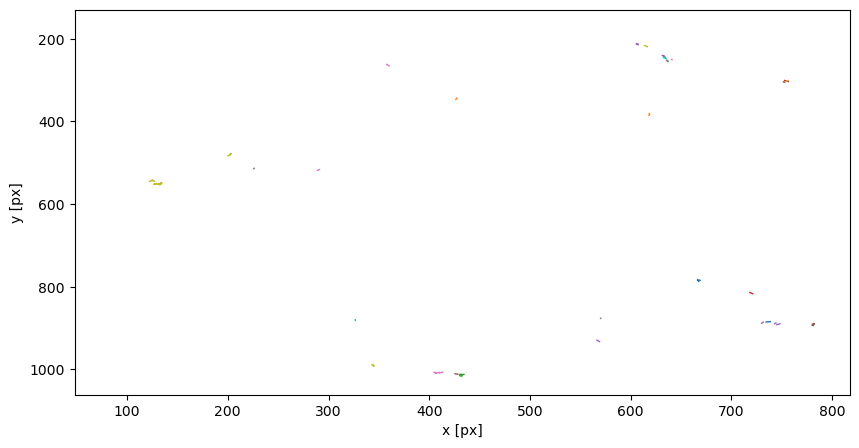

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

In [36]:
plt.figure()
tp.plot_traj(t2)

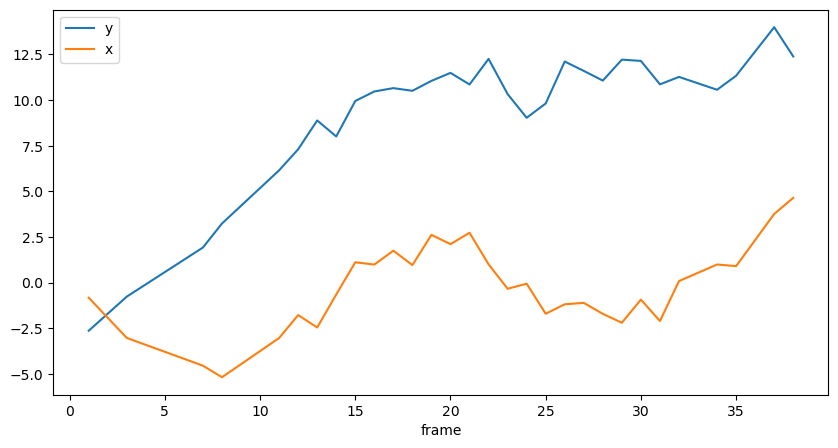

In [28]:
d = tp.compute_drift(t2)
d.plot()
plt.show()